In [1]:
import copy
import math
import keras 
import rawpy
import random

import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM,Embedding,Dropout,Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
torch.manual_seed(11)

In [2]:
from random import Random

def get_train_data(dataset, size_of_training):
    train_changed = [element for element in dataset if element[4] == 0][0:size_of_training]
    train_unchanged = [np.append(element[:-1],1) for element in dataset if element[4] == 255 ][0:size_of_training]
    train_data = list(np.vstack([train_changed, train_unchanged]))
    random.shuffle(train_data)
    train_data = np.array(train_data)

    trainX = train_data[:,:-1]
    trainY = train_data[:, -1]
    return trainX, trainY

def get_train_separated(dataset, size_of_training):
    train_changed = [element for element in dataset if element[4] == 0][0:size_of_training]
    train_unchanged = [np.append(element[:-1],1) for element in dataset if element[4] == 255 ][0:size_of_training]
    return train_changed, train_unchanged


def get_train_data_randomised(dataset, size_of_training):
    reshaped_dataset = copy.copy(dataset)
    print(f"element before shyffle {reshaped_dataset[0:10]}")
    Random(202).shuffle(reshaped_dataset)
    print(f" element after shuffle {reshaped_dataset[0:10]}")
    train_changed = [element for element in reshaped_dataset if element[4] == 0][0:size_of_training]
    train_unchanged = [np.append(element[:-1],1) for element in reshaped_dataset if element[4] == 255 ][0:size_of_training]
    train_data = list(np.vstack([train_changed, train_unchanged]))
    Random(202).shuffle(train_data)
    train_data = np.array(train_data)
    trainX = train_data[:,:-1]
    trainY = train_data[:, -1]
    return trainX, trainY

def import_data():
    lst_of_img = []
    for path in lst_path:
        npimg = np.fromfile(path, dtype=np.uint8)
        imageSize = (360, 512)
        npimg = npimg.reshape(imageSize)
        #npimg = cv.equalizeHist(npimg)
        lst_of_img.append(npimg)
    return lst_of_img

def reshape_data(trainX,trainY,X,Y):
    #X = sc.fit_transform(X)
    X = np.float32(np.reshape(X,(np.shape(X)[0],2,2)))
    Y = np.float32(np.reshape(Y,(np.shape(Y)[0],1)))
    #trainX = sc.transform(trainX)
    trainX = np.float32(np.reshape(trainX,(trainX.shape[0],2,2)))
    trainY = np.float32(np.reshape(trainY,(trainY.shape[0],1)))
    # X = X/255.0   #Value norm 
    # 
   
    return trainX, trainY, X, Y

def plot_hist_for_y(y): 
    fig = plt.figure()
    histograma = [0,0]
    for line in y:
        for clasa in line: 
            #print(int(clasa))
            histograma[int(clasa)] += 1
    ax = fig.add_axes([0,0,1,1])
    ax.bar(CATEGORIES,histograma)
    plt.show()
    
def define_cudnn_model():
    model = Sequential()
    model.add(CuDNNLSTM(128, input_shape=(2,2), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(CuDNNLSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model

def define_clasical_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(2,2), activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model


def score_model(size_of_training):
    lst_of_img = import_data()
    reshaped_dataset = np.array(np.reshape(lst_of_img, [5, 360*512])).transpose()

    X = reshaped_dataset[:,:-1]
    Y = [element if element == 0 else 1 for element in reshaped_dataset[:,-1] ] # 0 means changed

    trainX,trainY = get_train_data_randomised(reshaped_dataset, size_of_training)
    trainX,trainY,X,Y = reshape_data(trainX,trainY,X,Y)

    model = define_clasical_model()

    model.summary()
    es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.001,   patience=1,  min_lr=1e-5) 

    model.fit(trainX,
              trainY,
              epochs=200,
              batch_size=1,
              verbose=2,
              callbacks=[lrr,es_callback]
             )
    
    y_pred = np.argmax(model.predict(X[:]), axis=-1)
    y_pred_reshaped = np.reshape(y_pred,(360, 512))
    y_pred_reshaped = [[element if element == 0 else 255 for element in line] for line in y_pred_reshaped[:] ] # 0 means changed
    
    path  = f"./results_test_special/size_of_training_{size_of_training}/"
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
    
    plt.figure
    plt.title('LSTM classification')
    plt.imshow(y_pred_reshaped, cmap = "gray")
    plt.savefig(f'./results_test_special/size_of_training_{size_of_training}/LSTM_classif.png')

    plt.figure
    plt.title('GroundTruth')
    plt.imshow(lst_of_img[4], cmap = "gray")
    plt.savefig(f'./results_test_special/size_of_training_{size_of_training}/GroundTruth.png')

    val = copy.copy(lst_of_img[4])
    for i in range(0,360):
        for j in range(512):
            #print(f"lst_of_img[4] = {lst_of_img[4][i][j]},  y_pred_reshaped[i][j] = { y_pred_reshaped[i][j]}")
            val[i][j] = abs(lst_of_img[4][i][j] - y_pred_reshaped[i][j])

    wrong_count = 0
    correct_count = 0
    for line in val:
        for elem in line:
            if elem == 255:
                wrong_count += 1
            else:
                correct_count += 1
                
    file_name = f'./results_test_special/size_of_training_{size_of_training}/result.txt'
    
    with open(file_name, 'w') as x_file:
        x_file.write('{} size of train\n'.format(np.shape(trainX)))
    
    with open(file_name, 'a') as x_file:
        x_file.write('{} wrong_count\n'.format(wrong_count))
        
    print('The count of wrong predicted elemnts is ', wrong_count) 
    print('The count of correct predicted elemnts is ', correct_count) 
    with open(file_name, 'a') as x_file:
        x_file.write('{} correct_count\n'.format(correct_count))
        
    print(f"Kappa score for the opperation is: {cohen_kappa_score(y_pred,Y)}")
    with open(file_name, 'a') as x_file:
        x_file.write('{} cohen_kappa_score(y_pred,Y)\n'.format(cohen_kappa_score(y_pred,Y)))
        
    print(classification_report(Y, y_pred, digits=4))
    with open(file_name, 'a') as x_file:
        x_file.write('{} classification_report(Y, y_pred, digits=4)\n'.format(classification_report(Y, y_pred, digits=4)))
        
    cm = confusion_matrix(y_true = Y[:] ,y_pred = y_pred)
    print(cm)
    with open(file_name, 'a') as x_file:
        x_file.write('{} cm \n'.format(cm))
        
    plt.imshow(val, cmap = "gray")
    plt.title("white = wrong classified pixels")
    plt.savefig(f'./results_test_special/size_of_training_{size_of_training}/wrong_class_pixels.png')


    FN = cm[0][1]
    TP = cm[0][0]
    FP = cm[1][0]
    TN = cm[1][1]
    MA = FN/(TP + FN)*100    #missed alarm rate
    FA = FP/(TP + FP)*100    #False alarm rate
    P = TP/(TP+FP)*100
    A = (TP + TN)/(TP + FN + FP + TN)*100
    R = TP/(TP+FN)*100       #Recall (True Positive Rate)
    S = TN/(TN + FP)*100     #Transferability  (True Negative Rate)

    print(f"Precision: {P:.2f} %")
    print(f"Accuracy: {A:.2f} %")
    print(f"Recall (True Positive Rate): {R:.2f} %")
    print(f"Transferability  (True Negative Rate): {S:.2f} %")
    print(f"Missed alarm rate: {MA:.2f} %")
    print(f"False alarm rate: {FA:.2f} %")
    
    with open(file_name, 'a') as x_file:
        x_file.write(f'{P:.2f} Precision \n')
        x_file.write(f'{A:.2f} Accuracy \n')
        x_file.write(f'{R:.2f} Recall \n')
        x_file.write(f'{S:.2f} Transferability \n')
        x_file.write(f'{MA:.2f} Missed alarm rate \n')
        x_file.write(f'{FA:.2f} False alarm rate \n')
        




In [3]:
#Globals
CATEGORIES = ["CHANGED", "UNCHANGED"]
lst_path = ['.\Mexico\\aprile2000b4.raw',
           '.\Mexico\\aprile2000b5.raw',
           '.\Mexico\\maggio2002b4.raw',
           '.\Mexico\\maggio2002b5.raw',
           '.\Mexico\\groundtruth360x512.raw',          
           ]
size_of_training = 25
random.seed(101)
sc = StandardScaler()

(360, 512)
(360, 512)
(360, 512)
(360, 512)
(360, 512)


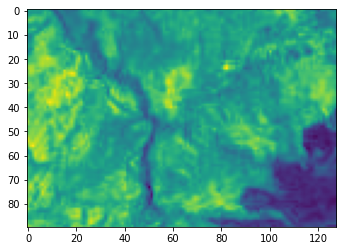

In [4]:
lst_of_img = import_data()
for i in range(0, len(lst_of_img)):
    print(np.shape(lst_of_img[i]))
    #plt.imshow(lst_of_img[i], cmap = "gray")
    #plt.show()
    
plt.imshow(lst_of_img[2][0:90,0:128])

In [5]:
print(np.shape(lst_of_img[0][0:90,384:512]))


(90, 128)


i = 0, y = 0, x = 0, y:y + 90 = 90, x:x + 128 = 128
(45, 64)
i = 1, y = 0, x = 0, y:y + 90 = 90, x:x + 128 = 128
(45, 64)
i = 2, y = 0, x = 0, y:y + 90 = 90, x:x + 128 = 128
(45, 64)
i = 3, y = 0, x = 0, y:y + 90 = 90, x:x + 128 = 128
(45, 64)
i = 4, y = 0, x = 0, y:y + 90 = 90, x:x + 128 = 128


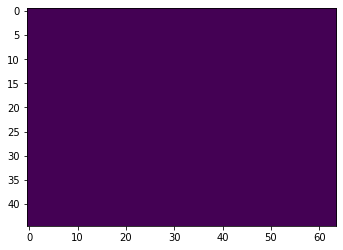

(45, 64)
i = 0, y = 0, x = 64, y:y + 90 = 90, x:x + 128 = 192
(45, 64)
i = 1, y = 0, x = 64, y:y + 90 = 90, x:x + 128 = 192
(45, 64)
i = 2, y = 0, x = 64, y:y + 90 = 90, x:x + 128 = 192
(45, 64)
i = 3, y = 0, x = 64, y:y + 90 = 90, x:x + 128 = 192
(45, 64)
i = 4, y = 0, x = 64, y:y + 90 = 90, x:x + 128 = 192


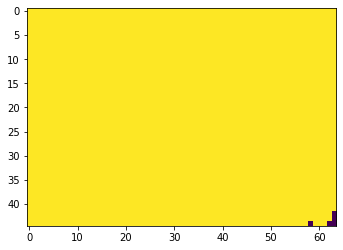

(45, 64)
i = 0, y = 0, x = 128, y:y + 90 = 90, x:x + 128 = 256
(45, 64)
i = 1, y = 0, x = 128, y:y + 90 = 90, x:x + 128 = 256
(45, 64)
i = 2, y = 0, x = 128, y:y + 90 = 90, x:x + 128 = 256
(45, 64)
i = 3, y = 0, x = 128, y:y + 90 = 90, x:x + 128 = 256
(45, 64)
i = 4, y = 0, x = 128, y:y + 90 = 90, x:x + 128 = 256


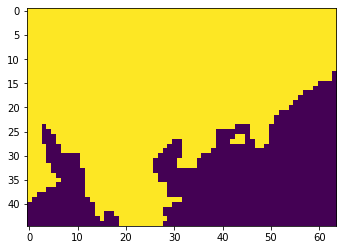

(45, 64)
i = 0, y = 0, x = 192, y:y + 90 = 90, x:x + 128 = 320
(45, 64)
i = 1, y = 0, x = 192, y:y + 90 = 90, x:x + 128 = 320
(45, 64)
i = 2, y = 0, x = 192, y:y + 90 = 90, x:x + 128 = 320
(45, 64)
i = 3, y = 0, x = 192, y:y + 90 = 90, x:x + 128 = 320
(45, 64)
i = 4, y = 0, x = 192, y:y + 90 = 90, x:x + 128 = 320


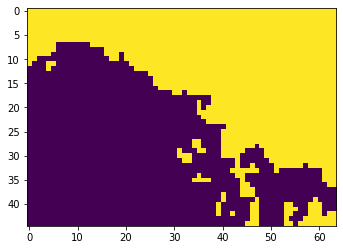

(45, 64)
i = 0, y = 0, x = 256, y:y + 90 = 90, x:x + 128 = 384
(45, 64)
i = 1, y = 0, x = 256, y:y + 90 = 90, x:x + 128 = 384
(45, 64)
i = 2, y = 0, x = 256, y:y + 90 = 90, x:x + 128 = 384
(45, 64)
i = 3, y = 0, x = 256, y:y + 90 = 90, x:x + 128 = 384
(45, 64)
i = 4, y = 0, x = 256, y:y + 90 = 90, x:x + 128 = 384


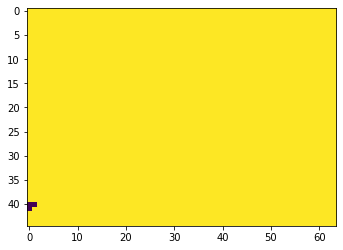

(45, 64)
i = 0, y = 0, x = 320, y:y + 90 = 90, x:x + 128 = 448
(45, 64)
i = 1, y = 0, x = 320, y:y + 90 = 90, x:x + 128 = 448
(45, 64)
i = 2, y = 0, x = 320, y:y + 90 = 90, x:x + 128 = 448
(45, 64)
i = 3, y = 0, x = 320, y:y + 90 = 90, x:x + 128 = 448
(45, 64)
i = 4, y = 0, x = 320, y:y + 90 = 90, x:x + 128 = 448


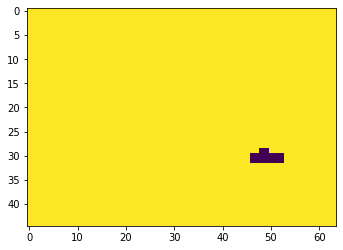

(45, 64)
i = 0, y = 0, x = 384, y:y + 90 = 90, x:x + 128 = 512
(45, 64)
i = 1, y = 0, x = 384, y:y + 90 = 90, x:x + 128 = 512
(45, 64)
i = 2, y = 0, x = 384, y:y + 90 = 90, x:x + 128 = 512
(45, 64)
i = 3, y = 0, x = 384, y:y + 90 = 90, x:x + 128 = 512
(45, 64)
i = 4, y = 0, x = 384, y:y + 90 = 90, x:x + 128 = 512


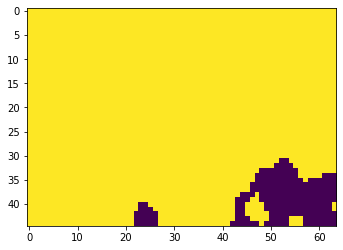

(45, 64)
i = 0, y = 0, x = 448, y:y + 90 = 90, x:x + 128 = 576
(45, 64)
i = 1, y = 0, x = 448, y:y + 90 = 90, x:x + 128 = 576
(45, 64)
i = 2, y = 0, x = 448, y:y + 90 = 90, x:x + 128 = 576
(45, 64)
i = 3, y = 0, x = 448, y:y + 90 = 90, x:x + 128 = 576
(45, 64)
i = 4, y = 0, x = 448, y:y + 90 = 90, x:x + 128 = 576


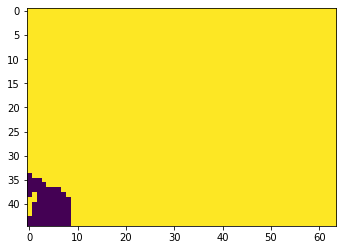

(45, 64)
i = 0, y = 45, x = 0, y:y + 90 = 135, x:x + 128 = 128
(45, 64)
i = 1, y = 45, x = 0, y:y + 90 = 135, x:x + 128 = 128
(45, 64)
i = 2, y = 45, x = 0, y:y + 90 = 135, x:x + 128 = 128
(45, 64)
i = 3, y = 45, x = 0, y:y + 90 = 135, x:x + 128 = 128
(45, 64)
i = 4, y = 45, x = 0, y:y + 90 = 135, x:x + 128 = 128


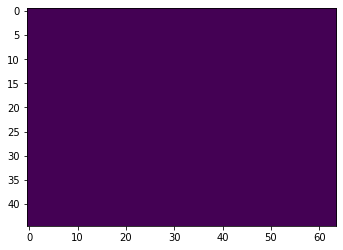

(45, 64)
i = 0, y = 45, x = 64, y:y + 90 = 135, x:x + 128 = 192
(45, 64)
i = 1, y = 45, x = 64, y:y + 90 = 135, x:x + 128 = 192
(45, 64)
i = 2, y = 45, x = 64, y:y + 90 = 135, x:x + 128 = 192
(45, 64)
i = 3, y = 45, x = 64, y:y + 90 = 135, x:x + 128 = 192
(45, 64)
i = 4, y = 45, x = 64, y:y + 90 = 135, x:x + 128 = 192


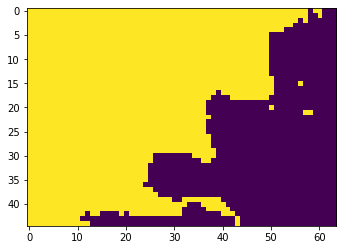

(45, 64)
i = 0, y = 45, x = 128, y:y + 90 = 135, x:x + 128 = 256
(45, 64)
i = 1, y = 45, x = 128, y:y + 90 = 135, x:x + 128 = 256
(45, 64)
i = 2, y = 45, x = 128, y:y + 90 = 135, x:x + 128 = 256
(45, 64)
i = 3, y = 45, x = 128, y:y + 90 = 135, x:x + 128 = 256
(45, 64)
i = 4, y = 45, x = 128, y:y + 90 = 135, x:x + 128 = 256


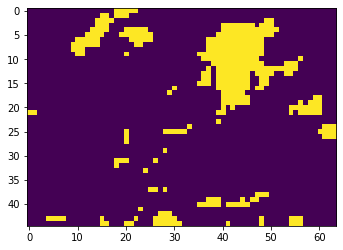

(45, 64)
i = 0, y = 45, x = 192, y:y + 90 = 135, x:x + 128 = 320
(45, 64)
i = 1, y = 45, x = 192, y:y + 90 = 135, x:x + 128 = 320
(45, 64)
i = 2, y = 45, x = 192, y:y + 90 = 135, x:x + 128 = 320
(45, 64)
i = 3, y = 45, x = 192, y:y + 90 = 135, x:x + 128 = 320
(45, 64)
i = 4, y = 45, x = 192, y:y + 90 = 135, x:x + 128 = 320


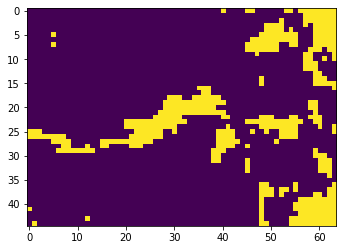

(45, 64)
i = 0, y = 45, x = 256, y:y + 90 = 135, x:x + 128 = 384
(45, 64)
i = 1, y = 45, x = 256, y:y + 90 = 135, x:x + 128 = 384
(45, 64)
i = 2, y = 45, x = 256, y:y + 90 = 135, x:x + 128 = 384
(45, 64)
i = 3, y = 45, x = 256, y:y + 90 = 135, x:x + 128 = 384
(45, 64)
i = 4, y = 45, x = 256, y:y + 90 = 135, x:x + 128 = 384


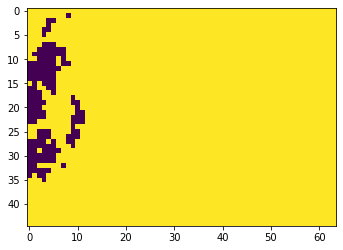

(45, 64)
i = 0, y = 45, x = 320, y:y + 90 = 135, x:x + 128 = 448
(45, 64)
i = 1, y = 45, x = 320, y:y + 90 = 135, x:x + 128 = 448
(45, 64)
i = 2, y = 45, x = 320, y:y + 90 = 135, x:x + 128 = 448
(45, 64)
i = 3, y = 45, x = 320, y:y + 90 = 135, x:x + 128 = 448
(45, 64)
i = 4, y = 45, x = 320, y:y + 90 = 135, x:x + 128 = 448


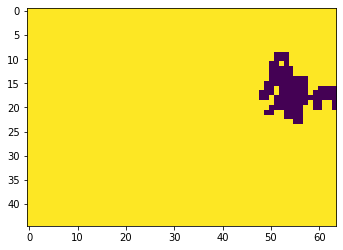

(45, 64)
i = 0, y = 45, x = 384, y:y + 90 = 135, x:x + 128 = 512
(45, 64)
i = 1, y = 45, x = 384, y:y + 90 = 135, x:x + 128 = 512
(45, 64)
i = 2, y = 45, x = 384, y:y + 90 = 135, x:x + 128 = 512
(45, 64)
i = 3, y = 45, x = 384, y:y + 90 = 135, x:x + 128 = 512
(45, 64)
i = 4, y = 45, x = 384, y:y + 90 = 135, x:x + 128 = 512


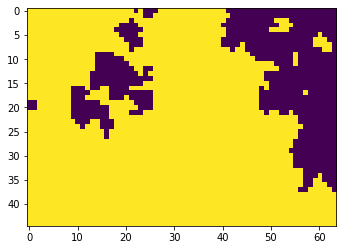

(45, 64)
i = 0, y = 45, x = 448, y:y + 90 = 135, x:x + 128 = 576
(45, 64)
i = 1, y = 45, x = 448, y:y + 90 = 135, x:x + 128 = 576
(45, 64)
i = 2, y = 45, x = 448, y:y + 90 = 135, x:x + 128 = 576
(45, 64)
i = 3, y = 45, x = 448, y:y + 90 = 135, x:x + 128 = 576
(45, 64)
i = 4, y = 45, x = 448, y:y + 90 = 135, x:x + 128 = 576


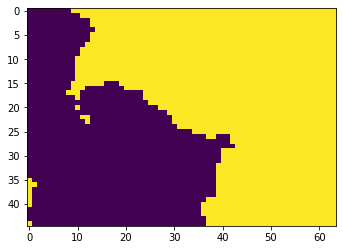

(45, 64)
i = 0, y = 90, x = 0, y:y + 90 = 180, x:x + 128 = 128
(45, 64)
i = 1, y = 90, x = 0, y:y + 90 = 180, x:x + 128 = 128
(45, 64)
i = 2, y = 90, x = 0, y:y + 90 = 180, x:x + 128 = 128
(45, 64)
i = 3, y = 90, x = 0, y:y + 90 = 180, x:x + 128 = 128
(45, 64)
i = 4, y = 90, x = 0, y:y + 90 = 180, x:x + 128 = 128


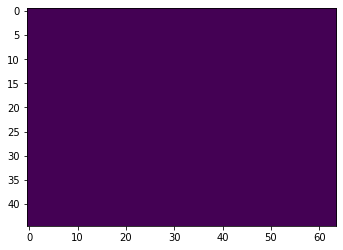

(45, 64)
i = 0, y = 90, x = 64, y:y + 90 = 180, x:x + 128 = 192
(45, 64)
i = 1, y = 90, x = 64, y:y + 90 = 180, x:x + 128 = 192
(45, 64)
i = 2, y = 90, x = 64, y:y + 90 = 180, x:x + 128 = 192
(45, 64)
i = 3, y = 90, x = 64, y:y + 90 = 180, x:x + 128 = 192
(45, 64)
i = 4, y = 90, x = 64, y:y + 90 = 180, x:x + 128 = 192


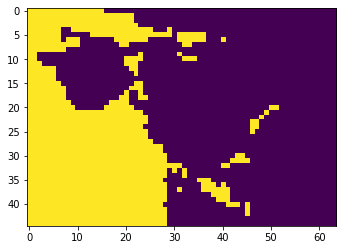

(45, 64)
i = 0, y = 90, x = 128, y:y + 90 = 180, x:x + 128 = 256
(45, 64)
i = 1, y = 90, x = 128, y:y + 90 = 180, x:x + 128 = 256
(45, 64)
i = 2, y = 90, x = 128, y:y + 90 = 180, x:x + 128 = 256
(45, 64)
i = 3, y = 90, x = 128, y:y + 90 = 180, x:x + 128 = 256
(45, 64)
i = 4, y = 90, x = 128, y:y + 90 = 180, x:x + 128 = 256


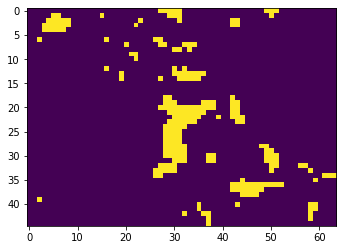

(45, 64)
i = 0, y = 90, x = 192, y:y + 90 = 180, x:x + 128 = 320
(45, 64)
i = 1, y = 90, x = 192, y:y + 90 = 180, x:x + 128 = 320
(45, 64)
i = 2, y = 90, x = 192, y:y + 90 = 180, x:x + 128 = 320
(45, 64)
i = 3, y = 90, x = 192, y:y + 90 = 180, x:x + 128 = 320
(45, 64)
i = 4, y = 90, x = 192, y:y + 90 = 180, x:x + 128 = 320


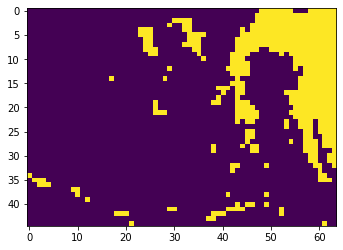

(45, 64)
i = 0, y = 90, x = 256, y:y + 90 = 180, x:x + 128 = 384
(45, 64)
i = 1, y = 90, x = 256, y:y + 90 = 180, x:x + 128 = 384
(45, 64)
i = 2, y = 90, x = 256, y:y + 90 = 180, x:x + 128 = 384
(45, 64)
i = 3, y = 90, x = 256, y:y + 90 = 180, x:x + 128 = 384
(45, 64)
i = 4, y = 90, x = 256, y:y + 90 = 180, x:x + 128 = 384


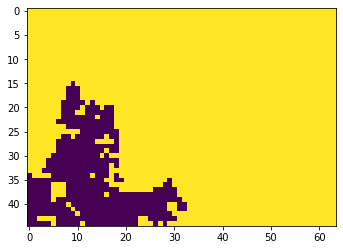

(45, 64)
i = 0, y = 90, x = 320, y:y + 90 = 180, x:x + 128 = 448
(45, 64)
i = 1, y = 90, x = 320, y:y + 90 = 180, x:x + 128 = 448
(45, 64)
i = 2, y = 90, x = 320, y:y + 90 = 180, x:x + 128 = 448
(45, 64)
i = 3, y = 90, x = 320, y:y + 90 = 180, x:x + 128 = 448
(45, 64)
i = 4, y = 90, x = 320, y:y + 90 = 180, x:x + 128 = 448


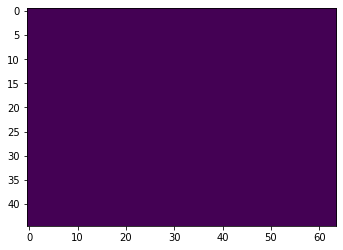

(45, 64)
i = 0, y = 90, x = 384, y:y + 90 = 180, x:x + 128 = 512
(45, 64)
i = 1, y = 90, x = 384, y:y + 90 = 180, x:x + 128 = 512
(45, 64)
i = 2, y = 90, x = 384, y:y + 90 = 180, x:x + 128 = 512
(45, 64)
i = 3, y = 90, x = 384, y:y + 90 = 180, x:x + 128 = 512
(45, 64)
i = 4, y = 90, x = 384, y:y + 90 = 180, x:x + 128 = 512


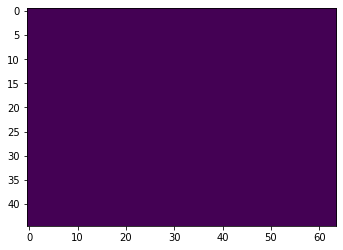

(45, 64)
i = 0, y = 90, x = 448, y:y + 90 = 180, x:x + 128 = 576
(45, 64)
i = 1, y = 90, x = 448, y:y + 90 = 180, x:x + 128 = 576
(45, 64)
i = 2, y = 90, x = 448, y:y + 90 = 180, x:x + 128 = 576
(45, 64)
i = 3, y = 90, x = 448, y:y + 90 = 180, x:x + 128 = 576
(45, 64)
i = 4, y = 90, x = 448, y:y + 90 = 180, x:x + 128 = 576


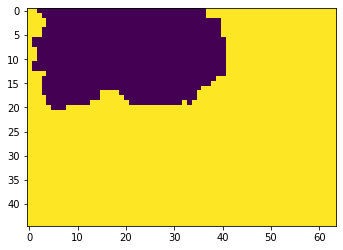

(45, 64)
i = 0, y = 135, x = 0, y:y + 90 = 225, x:x + 128 = 128
(45, 64)
i = 1, y = 135, x = 0, y:y + 90 = 225, x:x + 128 = 128
(45, 64)
i = 2, y = 135, x = 0, y:y + 90 = 225, x:x + 128 = 128
(45, 64)
i = 3, y = 135, x = 0, y:y + 90 = 225, x:x + 128 = 128
(45, 64)
i = 4, y = 135, x = 0, y:y + 90 = 225, x:x + 128 = 128


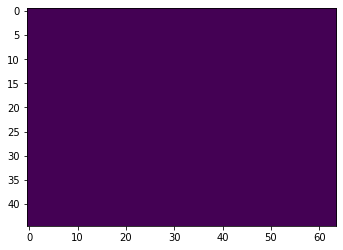

(45, 64)
i = 0, y = 135, x = 64, y:y + 90 = 225, x:x + 128 = 192
(45, 64)
i = 1, y = 135, x = 64, y:y + 90 = 225, x:x + 128 = 192
(45, 64)
i = 2, y = 135, x = 64, y:y + 90 = 225, x:x + 128 = 192
(45, 64)
i = 3, y = 135, x = 64, y:y + 90 = 225, x:x + 128 = 192
(45, 64)
i = 4, y = 135, x = 64, y:y + 90 = 225, x:x + 128 = 192


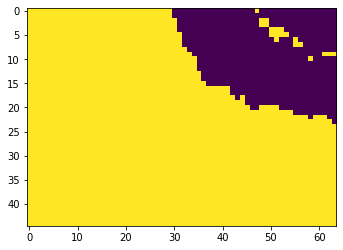

(45, 64)
i = 0, y = 135, x = 128, y:y + 90 = 225, x:x + 128 = 256
(45, 64)
i = 1, y = 135, x = 128, y:y + 90 = 225, x:x + 128 = 256
(45, 64)
i = 2, y = 135, x = 128, y:y + 90 = 225, x:x + 128 = 256
(45, 64)
i = 3, y = 135, x = 128, y:y + 90 = 225, x:x + 128 = 256
(45, 64)
i = 4, y = 135, x = 128, y:y + 90 = 225, x:x + 128 = 256


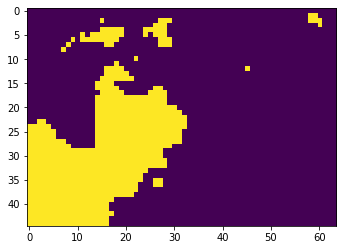

(45, 64)
i = 0, y = 135, x = 192, y:y + 90 = 225, x:x + 128 = 320
(45, 64)
i = 1, y = 135, x = 192, y:y + 90 = 225, x:x + 128 = 320
(45, 64)
i = 2, y = 135, x = 192, y:y + 90 = 225, x:x + 128 = 320
(45, 64)
i = 3, y = 135, x = 192, y:y + 90 = 225, x:x + 128 = 320
(45, 64)
i = 4, y = 135, x = 192, y:y + 90 = 225, x:x + 128 = 320


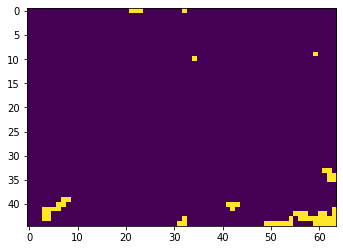

(45, 64)
i = 0, y = 135, x = 256, y:y + 90 = 225, x:x + 128 = 384
(45, 64)
i = 1, y = 135, x = 256, y:y + 90 = 225, x:x + 128 = 384
(45, 64)
i = 2, y = 135, x = 256, y:y + 90 = 225, x:x + 128 = 384
(45, 64)
i = 3, y = 135, x = 256, y:y + 90 = 225, x:x + 128 = 384
(45, 64)
i = 4, y = 135, x = 256, y:y + 90 = 225, x:x + 128 = 384


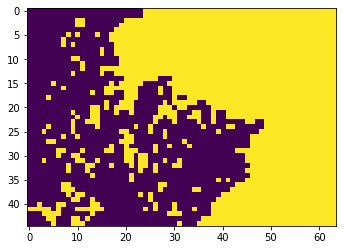

(45, 64)
i = 0, y = 135, x = 320, y:y + 90 = 225, x:x + 128 = 448
(45, 64)
i = 1, y = 135, x = 320, y:y + 90 = 225, x:x + 128 = 448
(45, 64)
i = 2, y = 135, x = 320, y:y + 90 = 225, x:x + 128 = 448
(45, 64)
i = 3, y = 135, x = 320, y:y + 90 = 225, x:x + 128 = 448
(45, 64)
i = 4, y = 135, x = 320, y:y + 90 = 225, x:x + 128 = 448


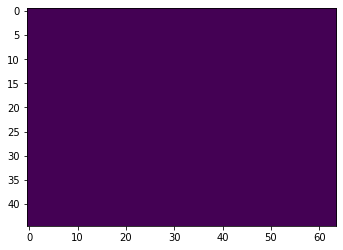

(45, 64)
i = 0, y = 135, x = 384, y:y + 90 = 225, x:x + 128 = 512
(45, 64)
i = 1, y = 135, x = 384, y:y + 90 = 225, x:x + 128 = 512
(45, 64)
i = 2, y = 135, x = 384, y:y + 90 = 225, x:x + 128 = 512
(45, 64)
i = 3, y = 135, x = 384, y:y + 90 = 225, x:x + 128 = 512
(45, 64)
i = 4, y = 135, x = 384, y:y + 90 = 225, x:x + 128 = 512


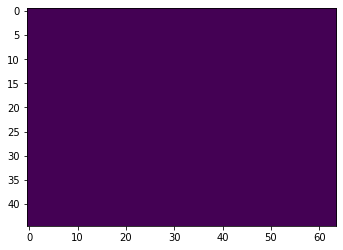

(45, 64)
i = 0, y = 135, x = 448, y:y + 90 = 225, x:x + 128 = 576
(45, 64)
i = 1, y = 135, x = 448, y:y + 90 = 225, x:x + 128 = 576
(45, 64)
i = 2, y = 135, x = 448, y:y + 90 = 225, x:x + 128 = 576
(45, 64)
i = 3, y = 135, x = 448, y:y + 90 = 225, x:x + 128 = 576
(45, 64)
i = 4, y = 135, x = 448, y:y + 90 = 225, x:x + 128 = 576


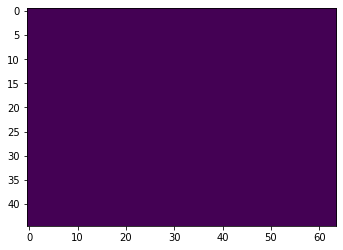

(45, 64)
i = 0, y = 180, x = 0, y:y + 90 = 270, x:x + 128 = 128
(45, 64)
i = 1, y = 180, x = 0, y:y + 90 = 270, x:x + 128 = 128
(45, 64)
i = 2, y = 180, x = 0, y:y + 90 = 270, x:x + 128 = 128
(45, 64)
i = 3, y = 180, x = 0, y:y + 90 = 270, x:x + 128 = 128
(45, 64)
i = 4, y = 180, x = 0, y:y + 90 = 270, x:x + 128 = 128


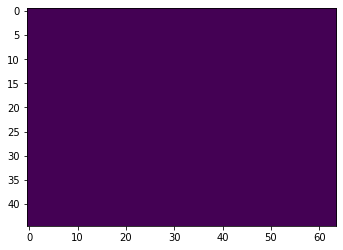

(45, 64)
i = 0, y = 180, x = 64, y:y + 90 = 270, x:x + 128 = 192
(45, 64)
i = 1, y = 180, x = 64, y:y + 90 = 270, x:x + 128 = 192
(45, 64)
i = 2, y = 180, x = 64, y:y + 90 = 270, x:x + 128 = 192
(45, 64)
i = 3, y = 180, x = 64, y:y + 90 = 270, x:x + 128 = 192
(45, 64)
i = 4, y = 180, x = 64, y:y + 90 = 270, x:x + 128 = 192


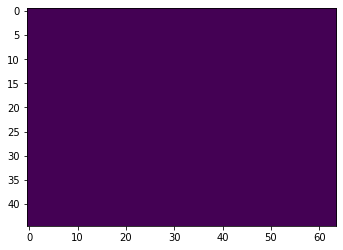

(45, 64)
i = 0, y = 180, x = 128, y:y + 90 = 270, x:x + 128 = 256
(45, 64)
i = 1, y = 180, x = 128, y:y + 90 = 270, x:x + 128 = 256
(45, 64)
i = 2, y = 180, x = 128, y:y + 90 = 270, x:x + 128 = 256
(45, 64)
i = 3, y = 180, x = 128, y:y + 90 = 270, x:x + 128 = 256
(45, 64)
i = 4, y = 180, x = 128, y:y + 90 = 270, x:x + 128 = 256


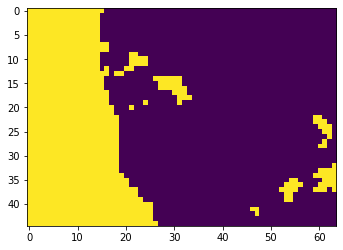

(45, 64)
i = 0, y = 180, x = 192, y:y + 90 = 270, x:x + 128 = 320
(45, 64)
i = 1, y = 180, x = 192, y:y + 90 = 270, x:x + 128 = 320
(45, 64)
i = 2, y = 180, x = 192, y:y + 90 = 270, x:x + 128 = 320
(45, 64)
i = 3, y = 180, x = 192, y:y + 90 = 270, x:x + 128 = 320
(45, 64)
i = 4, y = 180, x = 192, y:y + 90 = 270, x:x + 128 = 320


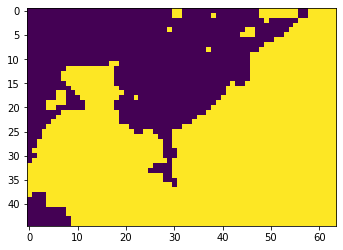

(45, 64)
i = 0, y = 180, x = 256, y:y + 90 = 270, x:x + 128 = 384
(45, 64)
i = 1, y = 180, x = 256, y:y + 90 = 270, x:x + 128 = 384
(45, 64)
i = 2, y = 180, x = 256, y:y + 90 = 270, x:x + 128 = 384
(45, 64)
i = 3, y = 180, x = 256, y:y + 90 = 270, x:x + 128 = 384
(45, 64)
i = 4, y = 180, x = 256, y:y + 90 = 270, x:x + 128 = 384


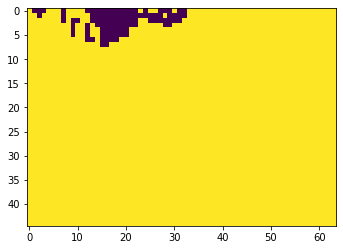

(45, 64)
i = 0, y = 180, x = 320, y:y + 90 = 270, x:x + 128 = 448
(45, 64)
i = 1, y = 180, x = 320, y:y + 90 = 270, x:x + 128 = 448
(45, 64)
i = 2, y = 180, x = 320, y:y + 90 = 270, x:x + 128 = 448
(45, 64)
i = 3, y = 180, x = 320, y:y + 90 = 270, x:x + 128 = 448
(45, 64)
i = 4, y = 180, x = 320, y:y + 90 = 270, x:x + 128 = 448


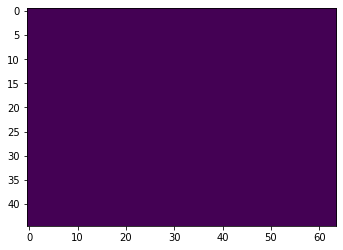

(45, 64)
i = 0, y = 180, x = 384, y:y + 90 = 270, x:x + 128 = 512
(45, 64)
i = 1, y = 180, x = 384, y:y + 90 = 270, x:x + 128 = 512
(45, 64)
i = 2, y = 180, x = 384, y:y + 90 = 270, x:x + 128 = 512
(45, 64)
i = 3, y = 180, x = 384, y:y + 90 = 270, x:x + 128 = 512
(45, 64)
i = 4, y = 180, x = 384, y:y + 90 = 270, x:x + 128 = 512


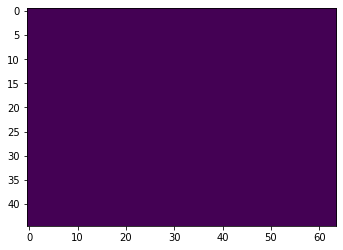

(45, 64)
i = 0, y = 180, x = 448, y:y + 90 = 270, x:x + 128 = 576
(45, 64)
i = 1, y = 180, x = 448, y:y + 90 = 270, x:x + 128 = 576
(45, 64)
i = 2, y = 180, x = 448, y:y + 90 = 270, x:x + 128 = 576
(45, 64)
i = 3, y = 180, x = 448, y:y + 90 = 270, x:x + 128 = 576
(45, 64)
i = 4, y = 180, x = 448, y:y + 90 = 270, x:x + 128 = 576


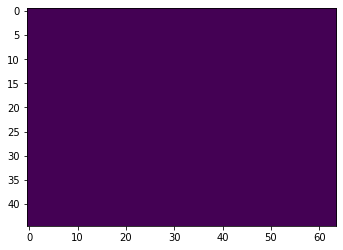

(45, 64)
i = 0, y = 225, x = 0, y:y + 90 = 315, x:x + 128 = 128
(45, 64)
i = 1, y = 225, x = 0, y:y + 90 = 315, x:x + 128 = 128
(45, 64)
i = 2, y = 225, x = 0, y:y + 90 = 315, x:x + 128 = 128
(45, 64)
i = 3, y = 225, x = 0, y:y + 90 = 315, x:x + 128 = 128
(45, 64)
i = 4, y = 225, x = 0, y:y + 90 = 315, x:x + 128 = 128


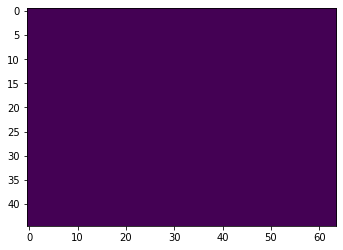

(45, 64)
i = 0, y = 225, x = 64, y:y + 90 = 315, x:x + 128 = 192
(45, 64)
i = 1, y = 225, x = 64, y:y + 90 = 315, x:x + 128 = 192
(45, 64)
i = 2, y = 225, x = 64, y:y + 90 = 315, x:x + 128 = 192
(45, 64)
i = 3, y = 225, x = 64, y:y + 90 = 315, x:x + 128 = 192
(45, 64)
i = 4, y = 225, x = 64, y:y + 90 = 315, x:x + 128 = 192


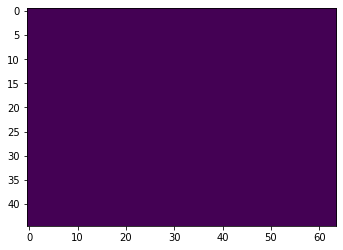

(45, 64)
i = 0, y = 225, x = 128, y:y + 90 = 315, x:x + 128 = 256
(45, 64)
i = 1, y = 225, x = 128, y:y + 90 = 315, x:x + 128 = 256
(45, 64)
i = 2, y = 225, x = 128, y:y + 90 = 315, x:x + 128 = 256
(45, 64)
i = 3, y = 225, x = 128, y:y + 90 = 315, x:x + 128 = 256
(45, 64)
i = 4, y = 225, x = 128, y:y + 90 = 315, x:x + 128 = 256


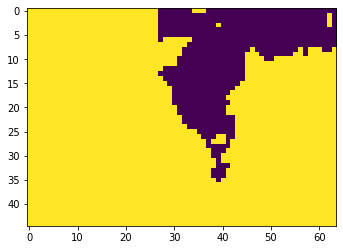

(45, 64)
i = 0, y = 225, x = 192, y:y + 90 = 315, x:x + 128 = 320
(45, 64)
i = 1, y = 225, x = 192, y:y + 90 = 315, x:x + 128 = 320
(45, 64)
i = 2, y = 225, x = 192, y:y + 90 = 315, x:x + 128 = 320
(45, 64)
i = 3, y = 225, x = 192, y:y + 90 = 315, x:x + 128 = 320
(45, 64)
i = 4, y = 225, x = 192, y:y + 90 = 315, x:x + 128 = 320


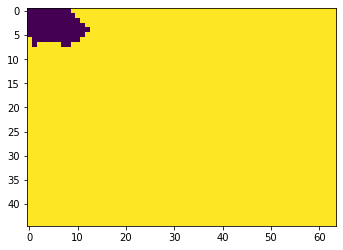

(45, 64)
i = 0, y = 225, x = 256, y:y + 90 = 315, x:x + 128 = 384
(45, 64)
i = 1, y = 225, x = 256, y:y + 90 = 315, x:x + 128 = 384
(45, 64)
i = 2, y = 225, x = 256, y:y + 90 = 315, x:x + 128 = 384
(45, 64)
i = 3, y = 225, x = 256, y:y + 90 = 315, x:x + 128 = 384
(45, 64)
i = 4, y = 225, x = 256, y:y + 90 = 315, x:x + 128 = 384


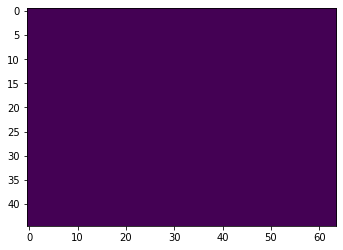

(45, 64)
i = 0, y = 225, x = 320, y:y + 90 = 315, x:x + 128 = 448
(45, 64)
i = 1, y = 225, x = 320, y:y + 90 = 315, x:x + 128 = 448
(45, 64)
i = 2, y = 225, x = 320, y:y + 90 = 315, x:x + 128 = 448
(45, 64)
i = 3, y = 225, x = 320, y:y + 90 = 315, x:x + 128 = 448
(45, 64)
i = 4, y = 225, x = 320, y:y + 90 = 315, x:x + 128 = 448


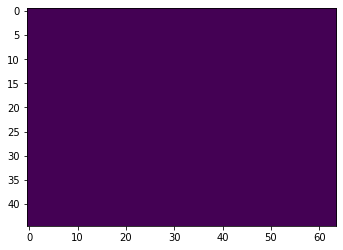

(45, 64)
i = 0, y = 225, x = 384, y:y + 90 = 315, x:x + 128 = 512
(45, 64)
i = 1, y = 225, x = 384, y:y + 90 = 315, x:x + 128 = 512
(45, 64)
i = 2, y = 225, x = 384, y:y + 90 = 315, x:x + 128 = 512
(45, 64)
i = 3, y = 225, x = 384, y:y + 90 = 315, x:x + 128 = 512
(45, 64)
i = 4, y = 225, x = 384, y:y + 90 = 315, x:x + 128 = 512


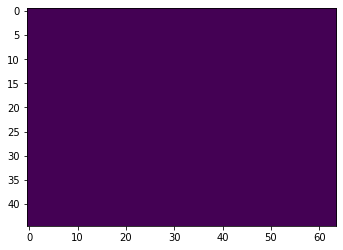

(45, 64)
i = 0, y = 225, x = 448, y:y + 90 = 315, x:x + 128 = 576
(45, 64)
i = 1, y = 225, x = 448, y:y + 90 = 315, x:x + 128 = 576
(45, 64)
i = 2, y = 225, x = 448, y:y + 90 = 315, x:x + 128 = 576
(45, 64)
i = 3, y = 225, x = 448, y:y + 90 = 315, x:x + 128 = 576
(45, 64)
i = 4, y = 225, x = 448, y:y + 90 = 315, x:x + 128 = 576


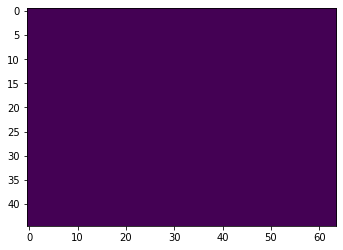

(45, 64)
i = 0, y = 270, x = 0, y:y + 90 = 360, x:x + 128 = 128
(45, 64)
i = 1, y = 270, x = 0, y:y + 90 = 360, x:x + 128 = 128
(45, 64)
i = 2, y = 270, x = 0, y:y + 90 = 360, x:x + 128 = 128
(45, 64)
i = 3, y = 270, x = 0, y:y + 90 = 360, x:x + 128 = 128
(45, 64)
i = 4, y = 270, x = 0, y:y + 90 = 360, x:x + 128 = 128


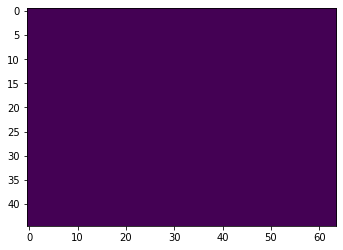

(45, 64)
i = 0, y = 270, x = 64, y:y + 90 = 360, x:x + 128 = 192
(45, 64)
i = 1, y = 270, x = 64, y:y + 90 = 360, x:x + 128 = 192
(45, 64)
i = 2, y = 270, x = 64, y:y + 90 = 360, x:x + 128 = 192
(45, 64)
i = 3, y = 270, x = 64, y:y + 90 = 360, x:x + 128 = 192
(45, 64)
i = 4, y = 270, x = 64, y:y + 90 = 360, x:x + 128 = 192


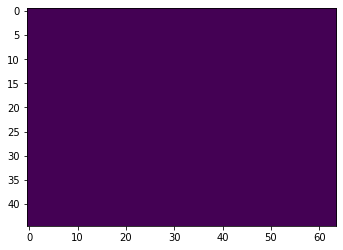

(45, 64)
i = 0, y = 270, x = 128, y:y + 90 = 360, x:x + 128 = 256
(45, 64)
i = 1, y = 270, x = 128, y:y + 90 = 360, x:x + 128 = 256
(45, 64)
i = 2, y = 270, x = 128, y:y + 90 = 360, x:x + 128 = 256
(45, 64)
i = 3, y = 270, x = 128, y:y + 90 = 360, x:x + 128 = 256
(45, 64)
i = 4, y = 270, x = 128, y:y + 90 = 360, x:x + 128 = 256


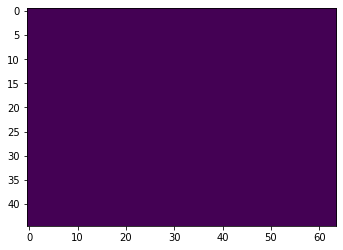

(45, 64)
i = 0, y = 270, x = 192, y:y + 90 = 360, x:x + 128 = 320
(45, 64)
i = 1, y = 270, x = 192, y:y + 90 = 360, x:x + 128 = 320
(45, 64)
i = 2, y = 270, x = 192, y:y + 90 = 360, x:x + 128 = 320
(45, 64)
i = 3, y = 270, x = 192, y:y + 90 = 360, x:x + 128 = 320
(45, 64)
i = 4, y = 270, x = 192, y:y + 90 = 360, x:x + 128 = 320


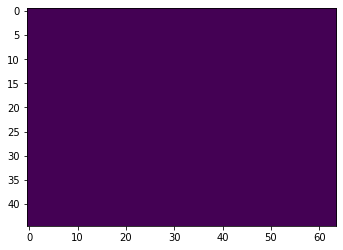

(45, 64)
i = 0, y = 270, x = 256, y:y + 90 = 360, x:x + 128 = 384
(45, 64)
i = 1, y = 270, x = 256, y:y + 90 = 360, x:x + 128 = 384
(45, 64)
i = 2, y = 270, x = 256, y:y + 90 = 360, x:x + 128 = 384
(45, 64)
i = 3, y = 270, x = 256, y:y + 90 = 360, x:x + 128 = 384
(45, 64)
i = 4, y = 270, x = 256, y:y + 90 = 360, x:x + 128 = 384


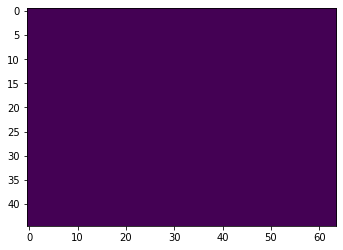

(45, 64)
i = 0, y = 270, x = 320, y:y + 90 = 360, x:x + 128 = 448
(45, 64)
i = 1, y = 270, x = 320, y:y + 90 = 360, x:x + 128 = 448
(45, 64)
i = 2, y = 270, x = 320, y:y + 90 = 360, x:x + 128 = 448
(45, 64)
i = 3, y = 270, x = 320, y:y + 90 = 360, x:x + 128 = 448
(45, 64)
i = 4, y = 270, x = 320, y:y + 90 = 360, x:x + 128 = 448


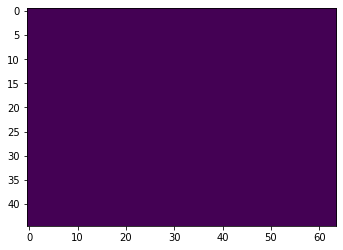

(45, 64)
i = 0, y = 270, x = 384, y:y + 90 = 360, x:x + 128 = 512
(45, 64)
i = 1, y = 270, x = 384, y:y + 90 = 360, x:x + 128 = 512
(45, 64)
i = 2, y = 270, x = 384, y:y + 90 = 360, x:x + 128 = 512
(45, 64)
i = 3, y = 270, x = 384, y:y + 90 = 360, x:x + 128 = 512
(45, 64)
i = 4, y = 270, x = 384, y:y + 90 = 360, x:x + 128 = 512


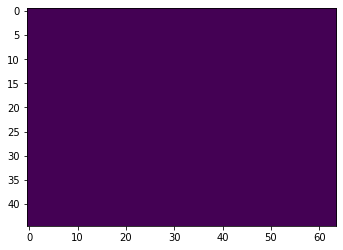

(45, 64)
i = 0, y = 270, x = 448, y:y + 90 = 360, x:x + 128 = 576
(45, 64)
i = 1, y = 270, x = 448, y:y + 90 = 360, x:x + 128 = 576
(45, 64)
i = 2, y = 270, x = 448, y:y + 90 = 360, x:x + 128 = 576
(45, 64)
i = 3, y = 270, x = 448, y:y + 90 = 360, x:x + 128 = 576
(45, 64)
i = 4, y = 270, x = 448, y:y + 90 = 360, x:x + 128 = 576


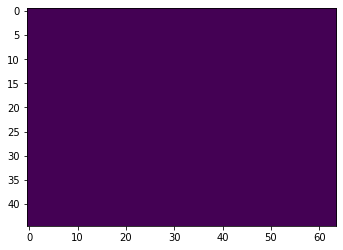

(45, 64)
i = 0, y = 315, x = 0, y:y + 90 = 405, x:x + 128 = 128
(45, 64)
i = 1, y = 315, x = 0, y:y + 90 = 405, x:x + 128 = 128
(45, 64)
i = 2, y = 315, x = 0, y:y + 90 = 405, x:x + 128 = 128
(45, 64)
i = 3, y = 315, x = 0, y:y + 90 = 405, x:x + 128 = 128
(45, 64)
i = 4, y = 315, x = 0, y:y + 90 = 405, x:x + 128 = 128


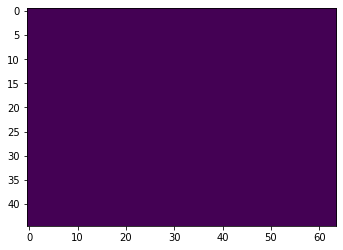

(45, 64)
i = 0, y = 315, x = 64, y:y + 90 = 405, x:x + 128 = 192
(45, 64)
i = 1, y = 315, x = 64, y:y + 90 = 405, x:x + 128 = 192
(45, 64)
i = 2, y = 315, x = 64, y:y + 90 = 405, x:x + 128 = 192
(45, 64)
i = 3, y = 315, x = 64, y:y + 90 = 405, x:x + 128 = 192
(45, 64)
i = 4, y = 315, x = 64, y:y + 90 = 405, x:x + 128 = 192


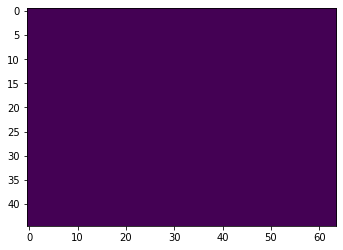

(45, 64)
i = 0, y = 315, x = 128, y:y + 90 = 405, x:x + 128 = 256
(45, 64)
i = 1, y = 315, x = 128, y:y + 90 = 405, x:x + 128 = 256
(45, 64)
i = 2, y = 315, x = 128, y:y + 90 = 405, x:x + 128 = 256
(45, 64)
i = 3, y = 315, x = 128, y:y + 90 = 405, x:x + 128 = 256
(45, 64)
i = 4, y = 315, x = 128, y:y + 90 = 405, x:x + 128 = 256


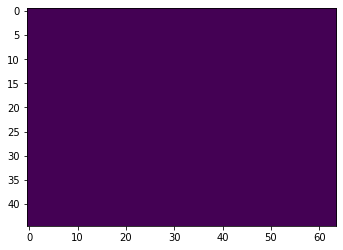

(45, 64)
i = 0, y = 315, x = 192, y:y + 90 = 405, x:x + 128 = 320
(45, 64)
i = 1, y = 315, x = 192, y:y + 90 = 405, x:x + 128 = 320
(45, 64)
i = 2, y = 315, x = 192, y:y + 90 = 405, x:x + 128 = 320
(45, 64)
i = 3, y = 315, x = 192, y:y + 90 = 405, x:x + 128 = 320
(45, 64)
i = 4, y = 315, x = 192, y:y + 90 = 405, x:x + 128 = 320


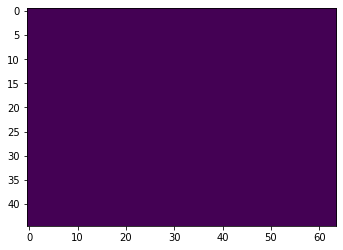

(45, 64)
i = 0, y = 315, x = 256, y:y + 90 = 405, x:x + 128 = 384
(45, 64)
i = 1, y = 315, x = 256, y:y + 90 = 405, x:x + 128 = 384
(45, 64)
i = 2, y = 315, x = 256, y:y + 90 = 405, x:x + 128 = 384
(45, 64)
i = 3, y = 315, x = 256, y:y + 90 = 405, x:x + 128 = 384
(45, 64)
i = 4, y = 315, x = 256, y:y + 90 = 405, x:x + 128 = 384


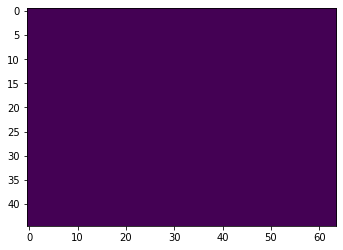

(45, 64)
i = 0, y = 315, x = 320, y:y + 90 = 405, x:x + 128 = 448
(45, 64)
i = 1, y = 315, x = 320, y:y + 90 = 405, x:x + 128 = 448
(45, 64)
i = 2, y = 315, x = 320, y:y + 90 = 405, x:x + 128 = 448
(45, 64)
i = 3, y = 315, x = 320, y:y + 90 = 405, x:x + 128 = 448
(45, 64)
i = 4, y = 315, x = 320, y:y + 90 = 405, x:x + 128 = 448


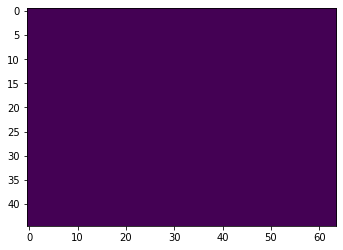

(45, 64)
i = 0, y = 315, x = 384, y:y + 90 = 405, x:x + 128 = 512
(45, 64)
i = 1, y = 315, x = 384, y:y + 90 = 405, x:x + 128 = 512
(45, 64)
i = 2, y = 315, x = 384, y:y + 90 = 405, x:x + 128 = 512
(45, 64)
i = 3, y = 315, x = 384, y:y + 90 = 405, x:x + 128 = 512
(45, 64)
i = 4, y = 315, x = 384, y:y + 90 = 405, x:x + 128 = 512


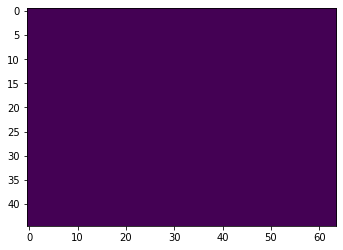

(45, 64)
i = 0, y = 315, x = 448, y:y + 90 = 405, x:x + 128 = 576
(45, 64)
i = 1, y = 315, x = 448, y:y + 90 = 405, x:x + 128 = 576
(45, 64)
i = 2, y = 315, x = 448, y:y + 90 = 405, x:x + 128 = 576
(45, 64)
i = 3, y = 315, x = 448, y:y + 90 = 405, x:x + 128 = 576
(45, 64)
i = 4, y = 315, x = 448, y:y + 90 = 405, x:x + 128 = 576


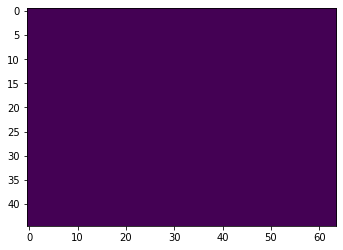

(45, 64)


In [6]:
train_img = []
test_img = []
train_img_1 = []
train_img_2 = []
train_img_3 = []
train_img_4 = []
train_img_5 = []
train_img_6 = []
train_img_7 = []
train_img_8 = []
train_img_9 = []

flag = True
for y in range(0, np.shape(lst_of_img[0])[0], 45):
    for x in range(0, np.shape(lst_of_img[0])[1], 64):
        # yield the current window
        for i in range (len(lst_of_img)):
            cropped_img = lst_of_img[i][y:y + 45, x:x + 64]
            if x == 128 and y == 0:
                train_img.append(cropped_img)
            elif x == 128 and y == 45 :
                train_img_1.append(cropped_img)
            elif x == 192 and y == 90 :
                train_img_2.append(cropped_img)
            elif x == 448 and y == 0 :
                train_img_3.append(cropped_img)
            elif x == 192 and y == 180 :
                train_img_4.append(cropped_img)
            elif x == 256 and y == 180 :
                train_img_5.append(cropped_img)
            elif x == 256 and y == 135 :
                train_img_6.append(cropped_img)
            elif x == 448 and y == 90 :
                train_img_7.append(cropped_img)
            elif x == 192 and y == 45 :
                train_img_8.append(cropped_img)
            elif x == 64 and y == 45 :
                train_img_9.append(cropped_img)
            else:
                test_img.append(cropped_img)
           
                
                
            print(f"i = {i}, y = {y}, x = {x}, y:y + 90 = {y + 90}, x:x + 128 = {x + 128}")
            if i ==4 :
                plt.imshow(cropped_img), plt.show()
            print(np.shape(cropped_img))

            if np.shape(cropped_img) != (90,128):
                continue


In [7]:
print(np.shape(train_img))
print(np.shape(train_img_1))
print(np.shape(train_img_2))
print(np.shape(train_img_3))
print(np.shape(train_img_4))
print(np.shape(train_img_9))

print(np.shape(test_img))

(5, 45, 64)
(5, 45, 64)
(5, 45, 64)
(5, 45, 64)
(5, 45, 64)
(5, 45, 64)
(270, 45, 64)


In [8]:
prev_model = tf.keras.applications.EfficientNetV2B1(
    weights=None,
    input_tensor=None,
    input_shape=(45,64,4),
    pooling=None,
    include_preprocessing=True,
)

# prev_model = tf.keras.applications.VGG16(
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     input_shape=(90,128,4),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

# prev_model = tf.keras.applications.MobileNet(
#     alpha=1.0,
#     depth_multiplier=1,
#     dropout=0.001,
#     include_top=False,
#     weights=None,
#     input_tensor=None,
#     input_shape=(45,64,4),
#     pooling=None
# )

model = Sequential()
model.add(prev_model)
#prev_model.summary()
model.add(Reshape((4,250,)))
#model.add(Reshape((1,1000,)))
#model.add(Flatten)
model.add(LSTM(256, activation='tanh',input_dim=4, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Flatten()) # tf.keras.layers.Flatten() 
model.add(Dense(5760, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(64*45, activation='sigmoid'))


C:\Users\ionut.girla\Anaconda3\envs\articol\lib\site-packages\keras\applications\efficientnet_v2.py:906: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  weights=weights)


In [9]:
#model.build((90,128,4)) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Function  (None, 1000)             8212412   
 al)                                                             
                                                                 
 reshape (Reshape)           (None, 4, 250)            0         
                                                                 
 lstm (LSTM)                 (None, 4, 256)            519168    
                                                                 
 dropout (Dropout)           (None, 4, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 dropout_1 (Dropout)         (None, 4, 128)            0         
                                                        

In [10]:
print(np.shape(train_img))
print(np.shape(test_img))

(5, 45, 64)
(270, 45, 64)


In [11]:

#model = define_cudnn_model()
#model = define_clasical_model()

model.summary()
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
lrr= ReduceLROnPlateau(monitor='loss',   factor=.5,   patience=10,  min_lr=1e-20) 

#validation_data=(X, Y)

#model.add(Dense(2))
#model.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])
#Model Summary

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Function  (None, 1000)             8212412   
 al)                                                             
                                                                 
 reshape (Reshape)           (None, 4, 250)            0         
                                                                 
 lstm (LSTM)                 (None, 4, 256)            519168    
                                                                 
 dropout (Dropout)           (None, 4, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 128)            197120    
                                                                 
 dropout_1 (Dropout)         (None, 4, 128)            0         
                                                        

In [12]:
print(np.shape(train_img))
trainX = np.expand_dims(np.rollaxis(np.array(train_img[0:4]), 0, 3),axis=0)
trainX_1 = np.expand_dims(np.rollaxis(np.array(train_img_1[0:4]), 0, 3),axis=0)
trainX_2 = np.expand_dims(np.rollaxis(np.array(train_img_2[0:4]), 0, 3),axis=0)
trainX_3 = np.expand_dims(np.rollaxis(np.array(train_img_3[0:4]), 0, 3),axis=0)
trainX_4 = np.expand_dims(np.rollaxis(np.array(train_img_4[0:4]), 0, 3),axis=0)
trainX_5 = np.expand_dims(np.rollaxis(np.array(train_img_5[0:4]), 0, 3),axis=0)
trainX_6 = np.expand_dims(np.rollaxis(np.array(train_img_6[0:4]), 0, 3),axis=0)
trainX_7 = np.expand_dims(np.rollaxis(np.array(train_img_7[0:4]), 0, 3),axis=0)
trainX_8 = np.expand_dims(np.rollaxis(np.array(train_img_8[0:4]), 0, 3),axis=0)
trainX_9 = np.expand_dims(np.rollaxis(np.array(train_img_9[0:4]), 0, 3),axis=0)

trainY = np.expand_dims(np.reshape(train_img[4],(45*64)),axis=0)
trainY_1 = np.expand_dims(np.reshape(train_img_1[4],(45*64)),axis=0)
trainY_2 = np.expand_dims(np.reshape(train_img_2[4],(45*64)),axis=0)
trainY_3 = np.expand_dims(np.reshape(train_img_3[4],(45*64)),axis=0)
trainY_4 = np.expand_dims(np.reshape(train_img_4[4],(45*64)),axis=0)
trainY_5 = np.expand_dims(np.reshape(train_img_5[4],(45*64)),axis=0)
trainY_6 = np.expand_dims(np.reshape(train_img_6[4],(45*64)),axis=0)
trainY_7 = np.expand_dims(np.reshape(train_img_7[4],(45*64)),axis=0)
trainY_8 = np.expand_dims(np.reshape(train_img_8[4],(45*64)),axis=0)
trainY_9 = np.expand_dims(np.reshape(train_img_9[4],(45*64)),axis=0)

trainX = np.concatenate((trainX, trainX_1), axis=0)
trainX = np.concatenate((trainX, trainX_2), axis=0)
trainX = np.concatenate((trainX, trainX_3), axis=0)
trainX = np.concatenate((trainX, trainX_4), axis=0)
trainX = np.concatenate((trainX, trainX_5), axis=0)
trainX = np.concatenate((trainX, trainX_6), axis=0)
trainX = np.concatenate((trainX, trainX_7), axis=0)
trainX = np.concatenate((trainX, trainX_8), axis=0)
trainX = np.concatenate((trainX, trainX_9), axis=0)

trainY = np.concatenate((trainY, trainY_1), axis=0)
trainY = np.concatenate((trainY, trainY_2), axis=0)
trainY = np.concatenate((trainY, trainY_3), axis=0)
trainY = np.concatenate((trainY, trainY_4), axis=0)
trainY = np.concatenate((trainY, trainY_5), axis=0)
trainY = np.concatenate((trainY, trainY_6), axis=0)
trainY = np.concatenate((trainY, trainY_7), axis=0)
trainY = np.concatenate((trainY, trainY_8), axis=0)
trainY = np.concatenate((trainY, trainY_9), axis=0)

print(np.shape(trainX))
print(np.shape(trainY))
# for i in range(4):
#     plt.imshow(trainX[0,:,:,i]), plt.show()
#     plt.imshow(trainX[1,:,:,i]), plt.show()


(5, 45, 64)
(10, 45, 64, 4)
(10, 2880)


In [14]:
trainY  = np.float32(trainY/255.0)

In [13]:
trainX  = np.float32(trainX/255.0)

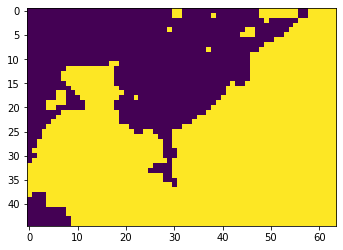

In [15]:
plt.imshow(np.reshape(trainY,(10,45,64))[4])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
model.fit(trainX,
          trainY,
          epochs=10000,
          batch_size=1,
          verbose=2,
          callbacks=[lrr,es_callback],
          
         )

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Epoch 1/10000


C:\Users\ionut.girla\Anaconda3\envs\articol\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


10/10 - 8s - loss: 5085543.0000 - accuracy: 0.4760 - lr: 0.5000 - 8s/epoch - 817ms/step
Epoch 2/10000
10/10 - 3s - loss: 9383366.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 338ms/step
Epoch 3/10000
10/10 - 3s - loss: 15551216.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 337ms/step
Epoch 4/10000
10/10 - 3s - loss: 18996904.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 334ms/step
Epoch 5/10000
10/10 - 3s - loss: 23901820.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 345ms/step
Epoch 6/10000
10/10 - 3s - loss: 27907078.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 343ms/step
Epoch 7/10000
10/10 - 3s - loss: 32505494.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoch - 343ms/step
Epoch 8/10000
10/10 - 4s - loss: 35992932.0000 - accuracy: 0.5652 - lr: 0.5000 - 4s/epoch - 352ms/step
Epoch 9/10000
10/10 - 4s - loss: 40009436.0000 - accuracy: 0.5652 - lr: 0.5000 - 4s/epoch - 389ms/step
Epoch 10/10000
10/10 - 3s - loss: 43685172.0000 - accuracy: 0.5652 - lr: 0.5000 - 3s/epoc

In [153]:
out = model.predict(trainX)

In [155]:
print(np.reshape(out,(10,45,64)))

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]]


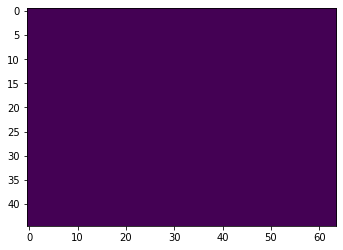

In [156]:
plt.imshow(np.reshape(out,(10,45,64))[0])

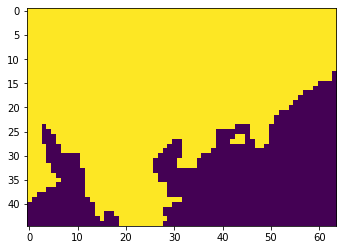

In [132]:
plt.imshow(train_img[4])

In [133]:
print(np.shape(test_img))
test_out = []
out = []
for i in range(0, 70, 5):
    print(i)
    #print(np.shape(test_img[i:i+4]))
    testX = np.expand_dims(np.rollaxis(np.array(test_img[i:i+4]), 0, 3),axis=0)
    
    testY = np.expand_dims(np.reshape(test_img[i+4],(45*64)),axis=0)
    #plt.imshow(np.reshape(testY,(90,128))), plt.show()
    
    out.append(model.predict(testX))
    test_out.append(np.reshape(testY,(45,64)))

    #print(np.shape(testX))
    #print(np.shape(testY))


(295, 45, 64)
0
5
10
15
20
25
30
35
40
45
50
55
60
65


In [134]:
print(np.shape(np.reshape(test_out,(14,45,64))))

(14, 45, 64)


In [135]:
print(np.shape(np.reshape(out,(14,45,64
                              
                              
                              ))))

(14, 45, 64)


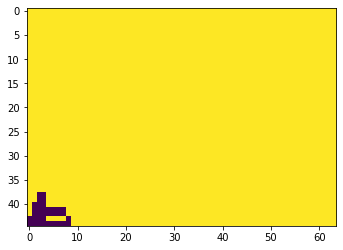

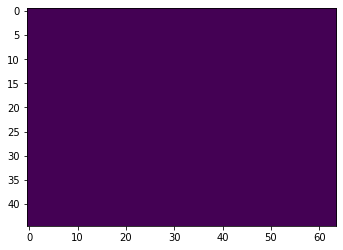

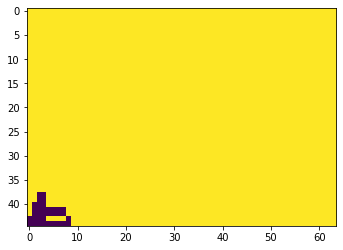

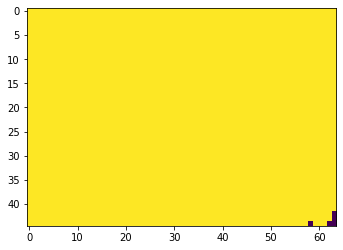

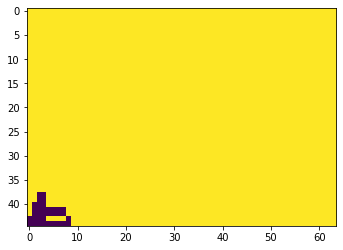

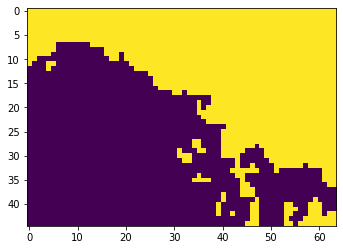

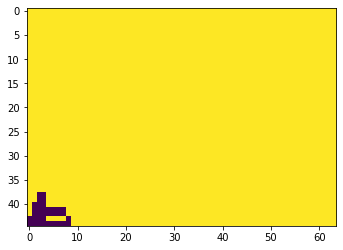

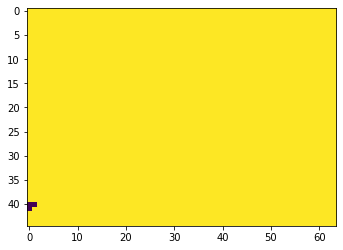

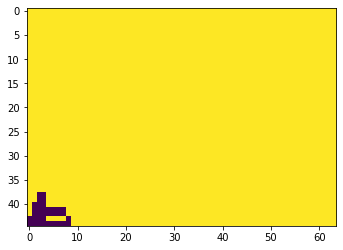

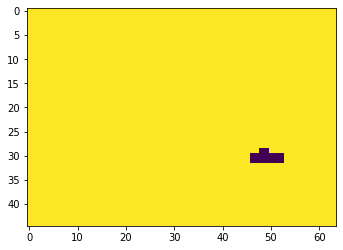

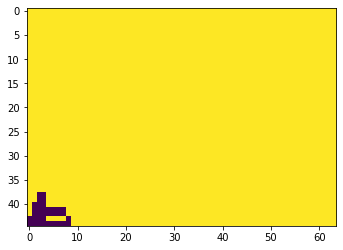

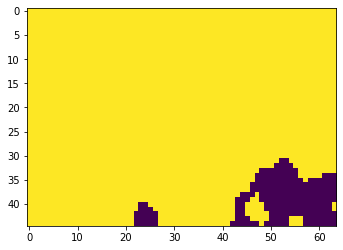

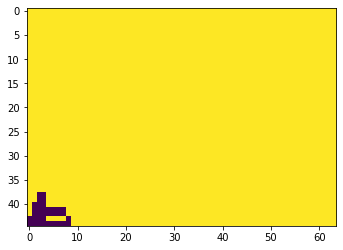

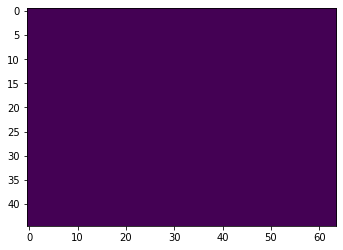

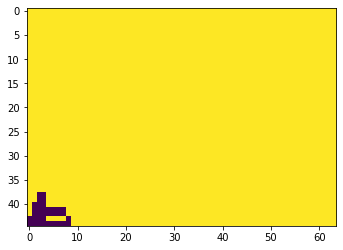

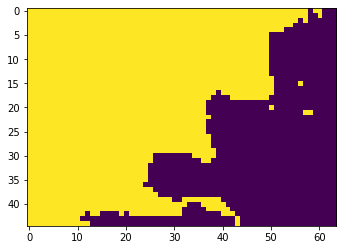

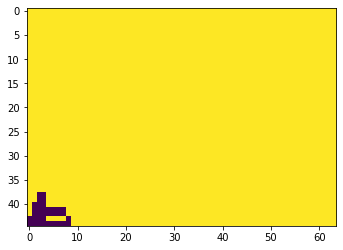

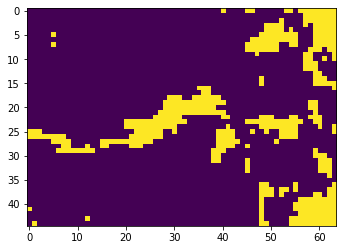

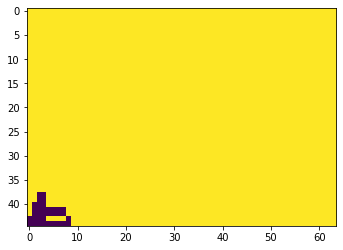

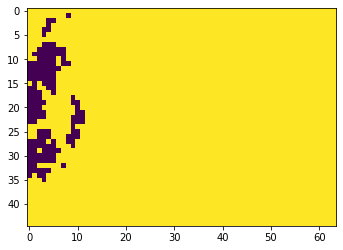

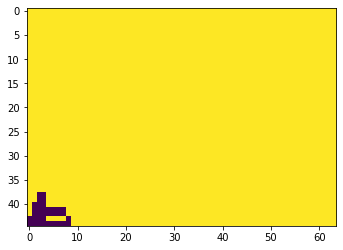

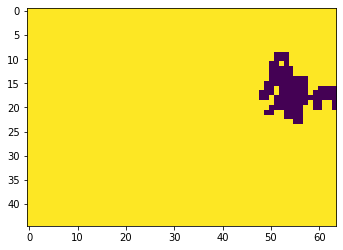

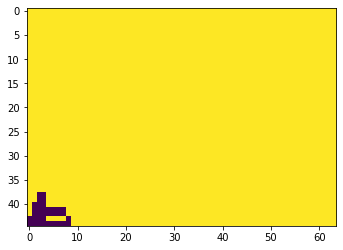

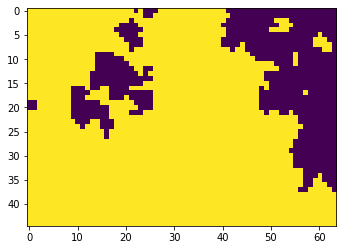

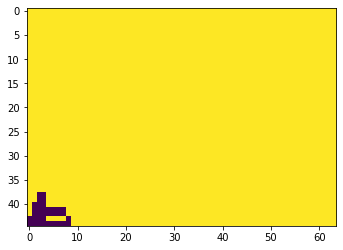

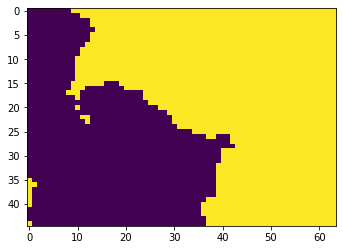

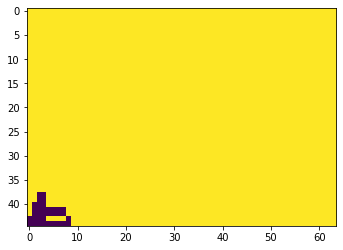

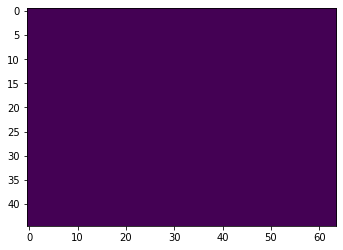

In [136]:
out_imgs = np.reshape(out,(14,45,64))
test_images = np.reshape(test_out,(14,45,64))
for i in range(14):
    plt.imshow(out_imgs[i]), plt.show()
    plt.imshow(test_images[i]), plt.show()
    

In [95]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
from keras import backend as K
from glob import glob
import numpy as np
import cv2
import random

In [96]:
trainX = []
trainY = []

flag = True
for y in range(0, np.shape(lst_of_img[0])[0], 4):
    for x in range(0, np.shape(lst_of_img[0])[1], 4):
        # yield the current window
        train_imgs = []
        for i in range (len(lst_of_img)):
            cropped_img = lst_of_img[i][y:y + 4, x:x + 4]
            if i != 4: 
                train_imgs.append(cropped_img)
            if i == 4:
                trainY.append(cropped_img)
        trainX.append(train_imgs)
            



In [97]:
print(np.shape(trainX))

(11520, 4, 4, 4)


In [98]:
print(np.shape(trainY))

(11520, 4, 4)


In [99]:
trainX = np.reshape(trainX,(11520,16,4))
trainY = np.reshape(trainY,(11520, 16))

In [100]:
print(np.shape(trainY))

(11520, 16)


In [101]:
print(trainY[0])

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255]


In [102]:
for i in range(len(trainY)):
    for j in range(len(trainY[i])):
        if trainY[i,j] == 255:
            trainY[i,j] = 1
        else:
            trainY[i,j] = 0

In [103]:
print(np.shape(trainY))
print(trainY[0])

(11520, 16)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [104]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.73)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(3110, 16, 4)
(8410, 16, 4)
(3110, 16)
(8410, 16)


In [105]:
drop_prob_1 = 0.5
input_shape=(16,4)

model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Reshape((4,4,4)))
model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same', name='conv1', activation="relu"))
model.add(layers.Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same', name='conv2', activation="relu"))
model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv3', activation='relu'))
model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv4', activation='relu'))
model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv5', activation='relu'))
model.add(layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv6', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2048, name='FC1'))
model.add(layers.Dropout(drop_prob_1))
model.add(layers.Dense(1024, name='FC2'))
model.add(layers.Dropout(drop_prob_1))

model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='sigmoid'))

#plot_model(model, to_file='homography_model.png', show_shapes=True)


#model = define_cudnn_model()
#model = define_clasical_model()

model.summary()
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
lrr= ReduceLROnPlateau(monitor='accuracy',   factor=.5,   patience=2,  min_lr=1e-20) 

#validation_data=(X, Y)

#model.add(Dense(2))
#model.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])
#Model Summary

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_22 (Reshape)        (None, 4, 4, 4)           0         
                                                                 
 conv1 (Conv2D)              (None, 4, 4, 64)          1088      
                                                                 
 conv2 (Conv2D)              (None, 4, 4, 64)          16448     
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 128)         73856     
                                                                 
 conv4 (Conv2D)              (None, 4, 4, 128)         147584    
                                                                 
 conv5 (Conv2D)              (None, 4, 4, 256)         295168    
                                                                 
 conv6 (Conv2D)              (None, 4, 4, 256)       

In [106]:
print(np.shape(trainX))
trainX = np.reshape(trainX,(11520,16,4))
print(np.shape(trainX))
print(np.shape(trainY))

(11520, 16, 4)
(11520, 16, 4)
(11520, 16)


In [107]:
tf.config.experimental_run_functions_eagerly(True)
model.fit(X_train,
          y_train,
          epochs=1000,
          batch_size=40,
          verbose=2,
          callbacks=[lrr,es_callback],
          
         )

Epoch 1/1000


C:\Users\ionut.girla\Anaconda3\envs\articol\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


78/78 - 2s - loss: 56.3291 - accuracy: 0.8335 - lr: 0.5000 - 2s/epoch - 31ms/step
Epoch 2/1000
78/78 - 2s - loss: 68.9233 - accuracy: 0.8450 - lr: 0.5000 - 2s/epoch - 26ms/step
Epoch 3/1000
78/78 - 2s - loss: 73.7255 - accuracy: 0.8450 - lr: 0.5000 - 2s/epoch - 25ms/step
Epoch 4/1000
78/78 - 2s - loss: 75.7646 - accuracy: 0.8450 - lr: 0.5000 - 2s/epoch - 25ms/step
Epoch 5/1000
78/78 - 2s - loss: 69.2645 - accuracy: 0.8450 - lr: 0.2500 - 2s/epoch - 25ms/step
Epoch 6/1000
78/78 - 2s - loss: 63.8859 - accuracy: 0.8450 - lr: 0.2500 - 2s/epoch - 25ms/step
Epoch 7/1000
78/78 - 2s - loss: 60.0527 - accuracy: 0.8450 - lr: 0.1250 - 2s/epoch - 25ms/step
Epoch 8/1000
78/78 - 2s - loss: 57.3516 - accuracy: 0.8450 - lr: 0.1250 - 2s/epoch - 25ms/step
Epoch 9/1000
78/78 - 2s - loss: 55.7092 - accuracy: 0.8450 - lr: 0.0625 - 2s/epoch - 25ms/step
Epoch 10/1000
78/78 - 2s - loss: 54.6499 - accuracy: 0.8450 - lr: 0.0625 - 2s/epoch - 25ms/step
Epoch 11/1000
78/78 - 2s - loss: 53.7549 - accuracy: 0.8450 - 

In [108]:
out = model.predict(X_test)

In [109]:
print(np.shape(out))

(8410, 16)


In [110]:
print(out[0])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [111]:
print(y_test[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [112]:
accuracy_score(y_test, out)

0.8082045184304399